<a href="https://colab.research.google.com/github/Santosh503/Python_Fundamentals_Assignment./blob/main/Linear_inp_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

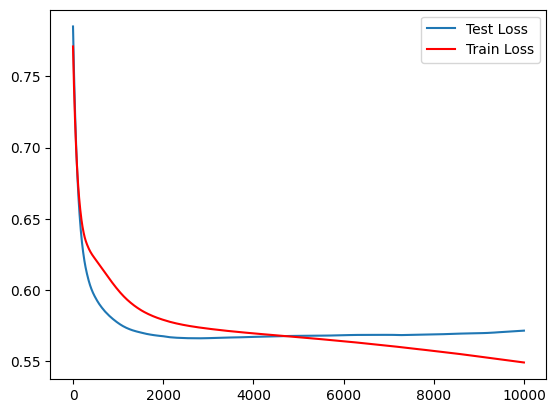

[[ 8 15]
 [ 5 51]]


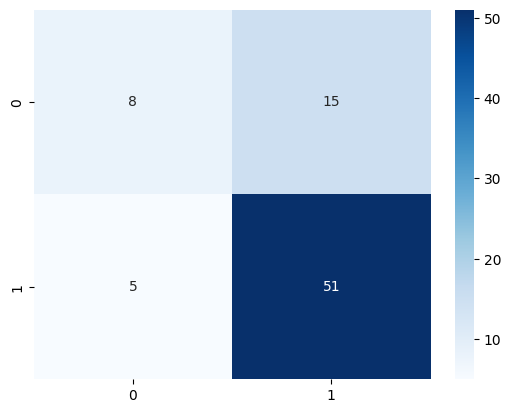

0.7468354430379747
Enter the number of past failures: 3
Enter the student's health status (1-5, 1=very bad, 5=very good): 3
Enter the student's age: 18
Enter the study time (1-4, 1= <2 hours, 4= >10 hours): 7
Prediction: The student is likely to PASS.


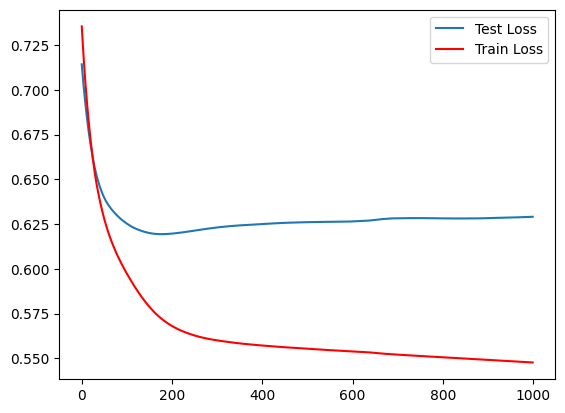

[[ 8 19]
 [ 3 49]]


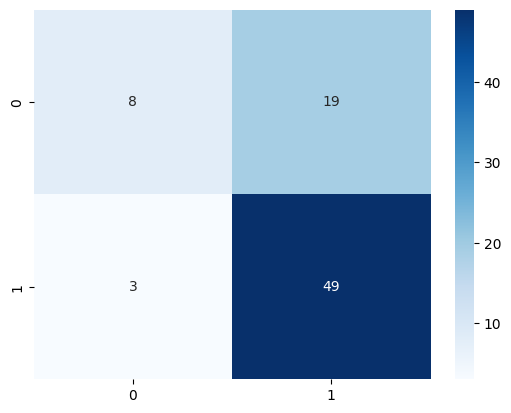

0.7215189873417721


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load data
df=pd.read_csv("final.csv")

# Feature and Target Selection
features=df[['failures','health','age','studytime']]
target=df['passed']

X=features.values
y=target.values

# Data Splitting
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2)

# Target label conversion to numerical
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})

# Data Scaling
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Convert to PyTorch tensors
X_train=torch.tensor(X_train, dtype=torch.float32)
X_test=torch.tensor(X_test, dtype=torch.float32)
y_train=torch.tensor(y_train, dtype = torch.int64)
y_test=torch.tensor(y_test, dtype = torch.int64)

# Neural Network Model
class MultiClassClassifier(nn.Module):
  def __init__(self):
    super(MultiClassClassifier, self).__init__()
    self.linear1=nn.Linear(4, 10)
    self.linear2=nn.Linear(10, 6)
    self.linear3=nn.Linear(6, 2)

  def forward(self, x):
    x1 = torch.relu(self.linear1(x))
    x2 = torch.relu(self.linear2(x1))
    x3 = self.linear3(x2)
    return x3

# Model, Loss and Optimizer
model = MultiClassClassifier()
loss = nn.CrossEntropyLoss()
criteria = torch.optim.SGD(model.parameters(), lr = 0.05)
num_epochs=1000

# Training loop
train_loss=[]
test_loss=[]
for ep in range(num_epochs):
  model.train()
  predicted_y = model(X_train)
  losses = loss(predicted_y, y_train)

  criteria.zero_grad()
  losses.backward()
  criteria.step()

  train_loss.append(losses.item())
  model.eval()
  with torch.no_grad():
    predicted_test_y=model(X_test)
    loss_test=loss(predicted_test_y,y_test)
    test_loss.append(loss_test.item())

# Plot Loss Curves
plt.plot(test_loss, label = 'Test Loss')
plt.plot(train_loss, color='red', label = 'Train Loss')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix

# Get predicted probabilities from the model
predicted_probs = model(X_test)

# Get predicted classes by selecting the class with the highest probability
predicted_classes = torch.argmax(predicted_probs, dim=1)

# Convert predicted_classes to numpy array to work with confusion_matrix
predicted_classes = predicted_classes.cpu().numpy()

cm = confusion_matrix(y_test, predicted_classes)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels='auto', yticklabels='auto')
plt.show()

#calculating accuracy
with torch.no_grad():
  outputs=model(X_test)
  _, predicted_classes=torch.max(outputs.data,1)  #get predicted classes

accuracy=(predicted_classes==y_test).sum().item()/y_test.size(0)
print(accuracy)


# User input and prediction
model.eval()
with torch.no_grad():
    failures = int(input("Enter the number of past failures: "))
    health = int(input("Enter the student's health status (1-5, 1=very bad, 5=very good): "))
    age = int(input("Enter the student's age: "))
    studytime = int(input("Enter the study time (1-4, 1= <2 hours, 4= >10 hours): "))

    user_input = np.array([[failures, health, age, studytime]], dtype=float)
    user_input_scaled = scaler.transform(user_input)
    user_input_tensor = torch.tensor(user_input_scaled, dtype=torch.float32)

    output = model(user_input_tensor)
    probabilities = torch.softmax(output, dim=1)  # Convert logits to probabilities using softmax
    predicted_class = torch.argmax(probabilities, dim=1).item()

    if predicted_class == 1:
        print("Prediction: The student is likely to PASS.")
    else:
        print("Prediction: The student is likely to FAIL.")